# Train Seq Model


In [32]:
import pandas as pd
from datasets import dataset_list
from sklearn.model_selection import StratifiedGroupKFold, train_test_split
from lightgbm import LGBMRegressor, plot_importance
from sklearn.base import clone
from sklearn.metrics import r2_score
import sglearn
import optuna
import joblib
from joblib import Parallel, delayed
import numpy as np
from datetime import datetime
import shap
import gpplot
import matplotlib.pyplot as plt

from core import (setup_plots,
                  lollipop_plot)

In [2]:
setup_plots()

In [3]:
def lgbm_training_iteration(fold_df, train_index, test_index, base_model):
    """Train lgbm model for optuna iterations

    :param fold_df: DataFrame
    :param train_index: list-like
    :param test_index: list-like
    :param base_model: LGBMRegressor
    :return: r^2
    """
    train_df = fold_df.iloc[train_index,:].reset_index(drop=True)
    train_df['sgRNA Activity'] = (train_df.groupby('dataset')
                                  ['sgRNA Activity']
                                  .rank(pct=True))
    X_train_val = sglearn.featurize_guides(train_df['sgRNA Context Sequence']) # train and validation data
    y_train_val = train_df['sgRNA Activity']
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                      test_size=0.1, random_state=7)
    model = clone(base_model)
    model.fit(X_train, y_train, early_stopping_rounds=20, eval_set=[(X_val, y_val)], verbose=False)
    test_df = fold_df.iloc[test_index,:].reset_index(drop=True)
    X_test = sglearn.featurize_guides(test_df['sgRNA Context Sequence'])
    test_predictions = test_df.copy()
    test_predictions['prediction'] = model.predict(X_test)
    test_predictions['sgRNA Activity'] = (test_predictions.groupby('dataset')
                                          ['sgRNA Activity']
                                          .rank(pct=True))
    r2 = r2_score(test_predictions['sgRNA Activity'], test_predictions['prediction'])
    return r2


def get_lgbm_objective(train_df):
    """Get objective function for training a lgbm model

    :param train_df: DataFrame
    :return: obejctive function
    """
    def objective(trial):
        """For training set, get optimal hyperparameters for lgbm

        :param trial: optuna.trial
        :return: int, pearson correlation with held out test data
        """
        sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=7)
        num_leaves = trial.suggest_int('num_leaves', 8, 256)
        min_child_samples = trial.suggest_int('min_child_samples', 8, 256)
        model = LGBMRegressor(random_state=7, n_jobs=1, learning_rate=0.01, n_estimators=5000,
                              num_leaves=num_leaves,
                              min_child_samples=min_child_samples)
        performance = Parallel(n_jobs=5)(delayed(lgbm_training_iteration)
                                         (train_df, train_index, test_index, model) for
                                         train_index, test_index in
                                         sgkf.split(train_df, train_df.dataset, train_df.target))
        avg_performance = np.mean(performance)
        return avg_performance
    return objective

In [4]:
train_data_names = pd.read_csv('../data/processed/train_data_names.csv').name.to_list()

In [5]:
train_data_list = list()
for ds in dataset_list:
    if ds.name in train_data_names:
        train_data_list.append(ds)

for ds in train_data_list:
    ds.load_data()
    ds.set_sgrnas()

In [6]:
sg_df_list = []
for ds in train_data_list:
    sg_df = ds.get_sg_df(include_group=True, include_activity=True)
    sg_df['dataset'] = ds.name
    sg_df_list.append(sg_df)
sg_df_groups = (pd.concat(sg_df_list)
                .groupby(['sgRNA Context Sequence'])
                .agg(n_conditions = ('sgRNA Context Sequence', 'count'),
                     target = ('sgRNA Target', lambda x: ', '.join(set([s.upper() for s in x if not pd.isna(s)]))))
                .reset_index())
multi_target = sg_df_groups['target'].str.contains(',').sum()
print('Context sequences with multiple targets: ' + str(multi_target))

Context sequences with multiple targets: 0


In [7]:
# handle singleton case
sg_df_groups['target'] = sg_df_groups.apply(lambda row:
                                            row['target'] if (row['target'] != '') else row['sgRNA Context Sequence'],
                                            axis=1)
# Note that 'target' is not in the sg_df_list, and is coming from the sg_df_groups df
sg_df_class_groups = (pd.concat(sg_df_list)
                      .merge(sg_df_groups, how='inner', on='sgRNA Context Sequence')
                      .sort_values(['dataset', 'target'])
                      .reset_index(drop=True))

## Training

In [8]:
n_trials = 50
study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.TPESampler(seed=7)) # maximize r^2
objective = get_lgbm_objective(sg_df_class_groups)
start_time = datetime.now()
study.optimize(objective, n_trials=n_trials)
end_time = datetime.now()
difference = end_time - start_time
print("Number of finished trials: {}".format(len(study.trials)))
print("Training Time: " + str(difference))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Using optimal parameters, retrain model with full dataset
train_df = sg_df_class_groups.copy()
train_df['sgRNA Activity'] = (train_df.groupby('dataset')
                              ['sgRNA Activity']
                              .rank(pct=True))
X_train_val = sglearn.featurize_guides(train_df['sgRNA Context Sequence'])
y_train_val = train_df['sgRNA Activity']
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                  test_size=0.1, random_state=7)
model = LGBMRegressor(random_state=7, n_jobs=8, learning_rate=0.01, n_estimators=5000,
                      **trial.params)
model.fit(X_train, y_train, early_stopping_rounds=20, eval_set=[(X_val, y_val)], verbose=1000)

[I 2021-05-19 16:31:04,308] A new study created in memory with name: no-name-388feace-c168-44b7-ac84-17c83245a3f7
[I 2021-05-19 16:31:34,057] Trial 0 finished with value: 0.4742675381313859 and parameters: {'num_leaves': 27, 'min_child_samples': 202}. Best is trial 0 with value: 0.4742675381313859.
[I 2021-05-19 16:32:05,250] Trial 1 finished with value: 0.47114440463070995 and parameters: {'num_leaves': 117, 'min_child_samples': 188}. Best is trial 0 with value: 0.4742675381313859.
[I 2021-05-19 16:32:38,595] Trial 2 finished with value: 0.4723192756228073 and parameters: {'num_leaves': 251, 'min_child_samples': 142}. Best is trial 0 with value: 0.4742675381313859.
[I 2021-05-19 16:33:08,008] Trial 3 finished with value: 0.4617150569010701 and parameters: {'num_leaves': 132, 'min_child_samples': 25}. Best is trial 0 with value: 0.4742675381313859.
[I 2021-05-19 16:33:38,384] Trial 4 finished with value: 0.47237781691967984 and parameters: {'num_leaves': 74, 'min_child_samples': 132}. 

Number of finished trials: 50
Training Time: 0:26:08.111464
Best trial:
  Value: 0.4753186904023128
  Params: 
    num_leaves: 31
    min_child_samples: 132
Training until validation scores don't improve for 20 rounds
[1000]	valid_0's l2: 0.0429661
Early stopping, best iteration is:
[1916]	valid_0's l2: 0.0419033


LGBMRegressor(learning_rate=0.01, min_child_samples=132, n_estimators=5000,
              n_jobs=8, random_state=7)

### Feature Importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

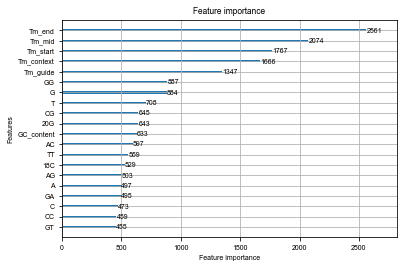

In [12]:
plot_importance(model, max_num_features=20)

In [13]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

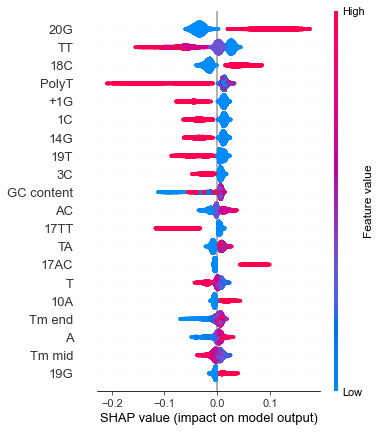

In [28]:
shap.summary_plot(shap_values, X_train, show=False, plot_size=(5, 7))
gpplot.savefig('../figures/seq_shap_summary_plot.pdf', dpi=300)

In [29]:
shap_df = pd.DataFrame(shap_values, columns=X_train.columns)
shap_abs_importance = (shap_df.abs().mean(0)
                       .reset_index()
                       .rename({0: 'importance',
                                'index': 'feature'}, axis=1)
                       .sort_values('importance', ascending=False))
top_n = 20
top_features = shap_abs_importance.head(top_n).copy()
top_features['feature'] = pd.Categorical(top_features['feature'], categories=top_features['feature'])

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning:

Saving 2.2 x 2.4 in image.

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning:

Filename: ../figures/seq_shap_feature_importance.pdf



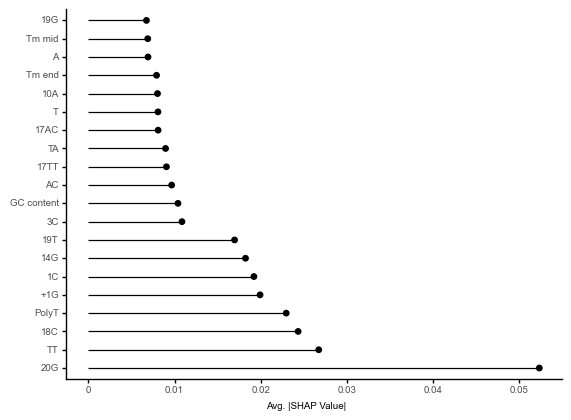

<ggplot: (8788080125895)>

In [39]:
g = lollipop_plot(top_features, 'feature', 'importance', xlabel='Avg. |SHAP Value|', ylabel='')
g.save('../figures/seq_shap_feature_importance.pdf', width=2.2, height=2.4)
g

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning:

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.



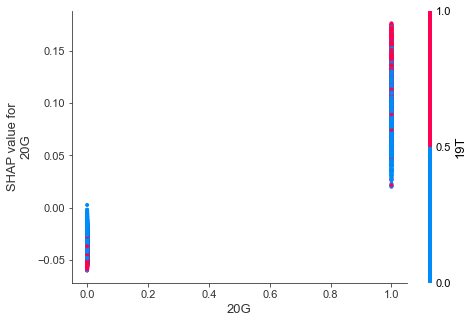

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning:

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.



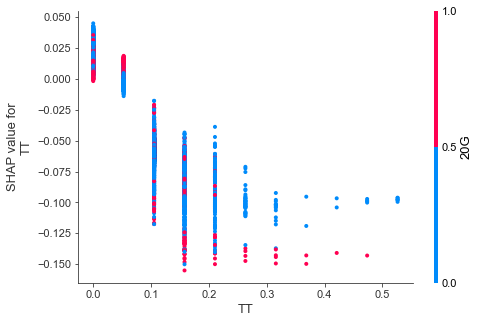

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning:

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.



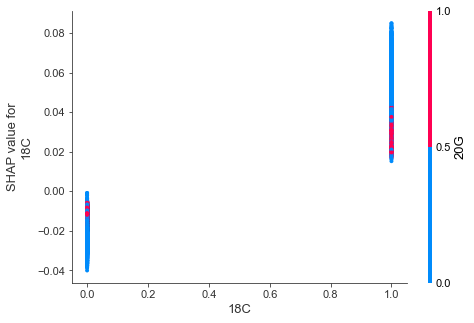

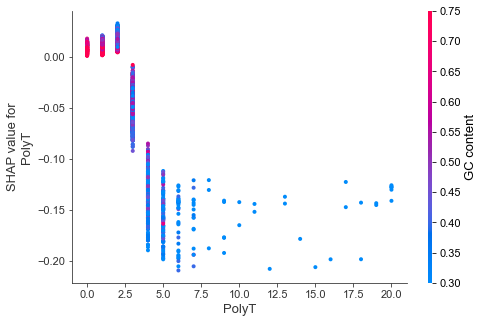

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning:

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.



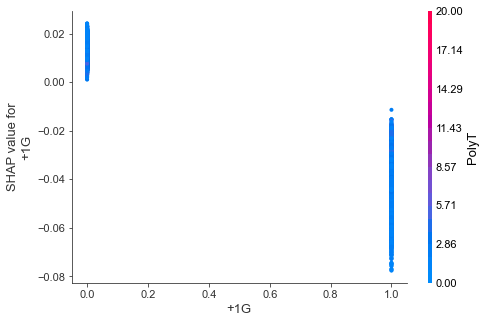

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning:

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.



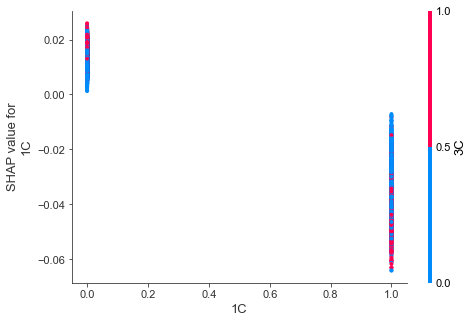

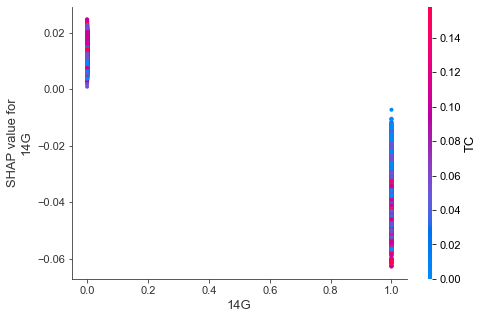

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning:

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.



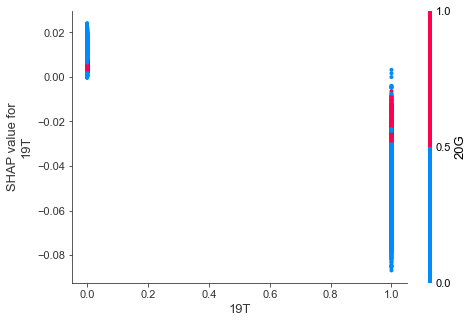

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning:

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.



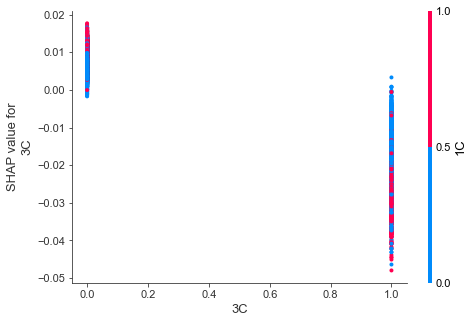

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning:

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.



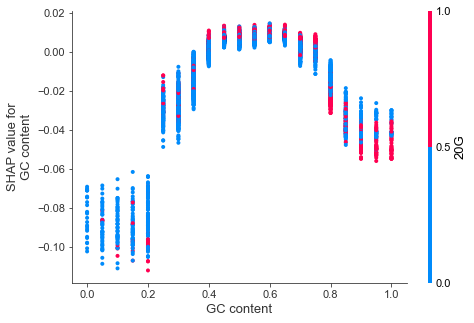

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning:

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.



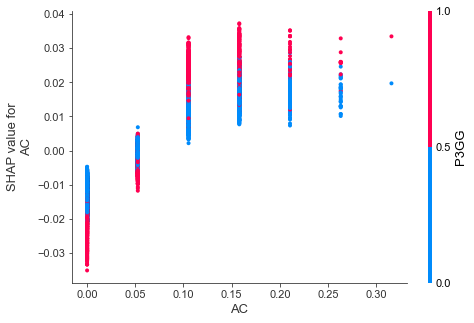

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning:

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.



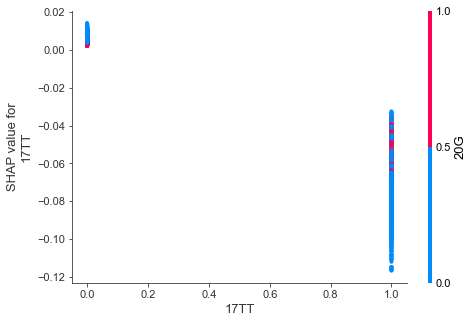

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning:

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.



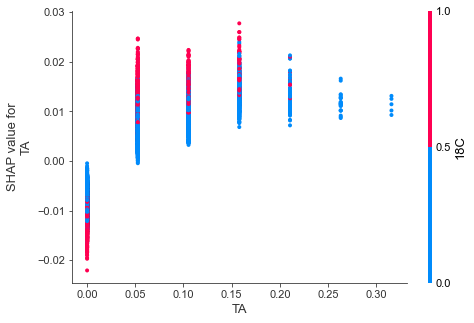

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning:

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.



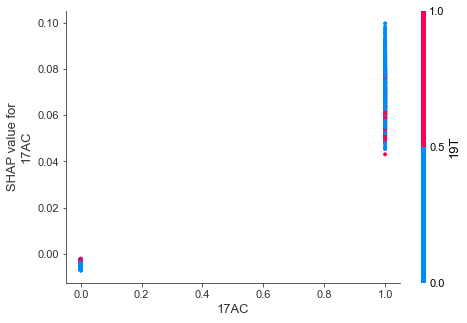

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning:

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.



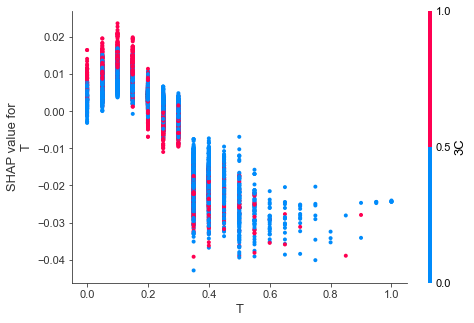

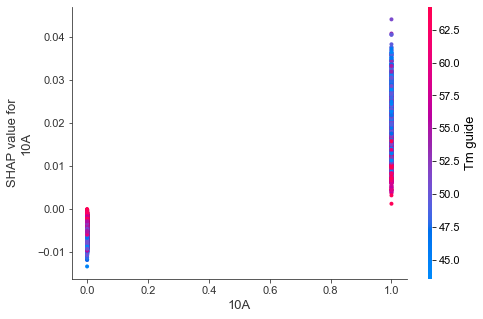

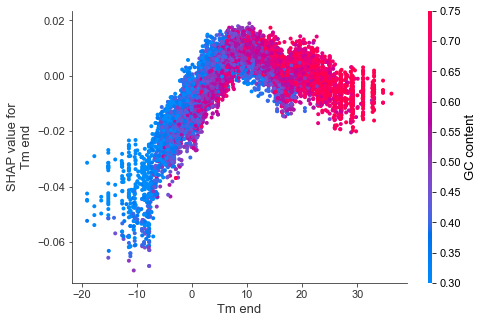

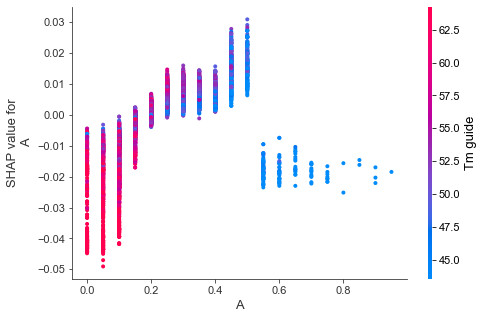

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning:

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.



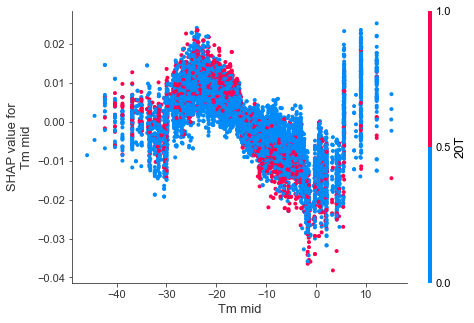

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning:

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.



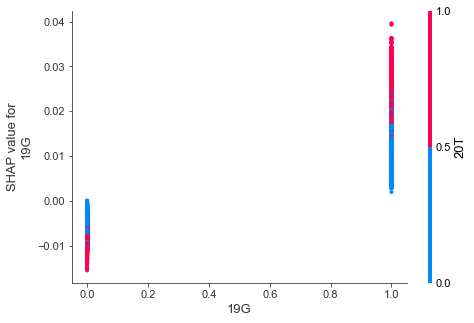

In [40]:
for feature in top_features['feature']:
    shap.dependence_plot(feature, shap_values, X_train)

In [60]:
interesting_features = ['20G', 'PolyT', 'GC content', 'Tm end']

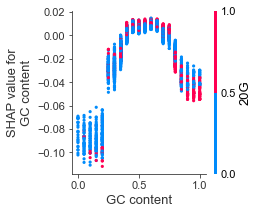

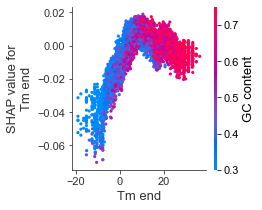

In [61]:
for ft in interesting_features:
    shap.dependence_plot(ft, shap_values, X_train, show=False, dot_size=10)
    fig = plt.gcf()
    fig.set_figheight(3)
    fig.set_figwidth(3)
    gpplot.savefig('../figures/seq_shap_' + ft + '_plot.pdf', dpi=300)

## Output Model

In [62]:
joblib.dump(model, '../models/RuleSet3.pkl')

['../models/RuleSet3.pkl']